In [445]:
from typing import Sequence
import numpy as np
from TwoDimProblem import TwoDimProblem
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Define Functions and MLP

### Activation Functions

In [2]:
def sigmoid(X: np.ndarray):
    return 1.0 / (1.0 + np.exp(-X))
def dSigmoid(X: np.ndarray):
    a = 1.0 / (1.0 + np.exp(-X))
    return a*(1-a)

def tanh(X: np.ndarray):
    return np.tanh(X)
def dTanh(X: np.ndarray):
    return 1.0 - np.tanh(X)**2

### Hidden Layer

In [464]:
class MultiLayerPerceptron:
    def __init__(
        self,
        epochs: int,
        lr: float,
        input_layer: int,
        output_layer: int,
        hidden_layers: Sequence[int],
        activation: str = "sigmoid",
    ):
        self.num_epochs = epochs
        self.lr = lr
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.hidden_layers = hidden_layers
        self._structure = (input_layer, *hidden_layers, output_layer)
        self._num_layers = len(self._structure)

        match activation:
            case "sigmoid" | "logistic":
                self.activation = sigmoid
                self.dActivation = dSigmoid
            case "tanh":
                self.activation = tanh
                self.dActivation = dTanh
            case _:
                raise ValueError("Invalid activation function")

        self._biases = [np.zeros((y, 1)) for y in self._structure[1:]]
        self._weights = [np.zeros((x,y)) for x, y in zip(self._structure[:-1], self._structure[1:])]
        self.loss_curve = []
    
    def epochs(self):
        for i in range(self.num_epochs):
            yield i, self.lr
    
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size: int = 1) -> None:
        self._biases = [np.random.randn(y, 1) for y in self._structure[1:]]
        self._weights = [np.random.randn(x,y) for x, y in zip(self._structure[:-1], self._structure[1:])]
        for epoch_num, lr in tqdm(self.epochs(), total=self.num_epochs):
            loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                dJdB, dJdW = self._batch_backprop(X_batch, y_batch)
                loss += self._calc_loss(X_batch, y_batch)
                self._biases = [b - lr * db for b, db in zip(self._biases, dJdB)]
                self._weights = [w - lr * dw for w, dw in zip(self._weights, dJdW)]
            self.loss_curve.append(loss)
        
    def predict(self, X_list: np.ndarray) -> np.ndarray:
        pred = []
        for X in X_list:
            curr = X[:, np.newaxis]
            for W, b in zip(self._weights, self._biases):
                z = W.T @ curr + b
                curr = self.activation(z)
            actual = 1 if z > 0 else 0
            pred.append(actual)
        return np.array(pred)

    def _batch_backprop(self, 
        X_batch: np.ndarray | list[np.ndarray], 
        y_batch: np.ndarray | list[np.ndarray]) -> tuple[list[np.ndarray], list[np.ndarray]]:

        dJdB = [np.zeros(b.shape) for b in self._biases]
        dJdW = [np.zeros(w.shape) for w in self._weights]
        batch_size = len(X_batch)
        for X, y in zip(X_batch, y_batch):
            dB, dW = self._backprop(X, y)
            dJdB = [db + ddb for db, ddb in zip(dJdB, dB)]
            dJdW = [dw + ddw for dw, ddw in zip(dJdW, dW)]
        dJdB = [db / batch_size for db in dJdB]
        dJdW = [dw / batch_size for dw in dJdW]
        return (dJdB, dJdW)
    
    def _backprop(self, X: np.ndarray, y: np.ndarray) -> tuple[list[np.ndarray], list[np.ndarray]]:
        dJdB = [np.zeros(b.shape) for b in self._biases]
        dJdW = [np.zeros(w.shape) for w in self._weights]
        if X.ndim == 1:
            X = X[:, np.newaxis]
        layer_raw = []
        layer_activations = []
        a = X
        for b, W in zip(self._biases, self._weights):
            z = W.T @ a + b 
            a = self.activation(z)
            layer_raw.append(z)
            layer_activations.append(a)
        
        # For last layer, compare to y
        H = self._num_layers - 2
        delta = (layer_activations[H] - y) * self.dActivation(layer_raw[H])
        dJdB[H] = delta
        dJdW[H] = layer_activations[H-1] @ delta.T

        # For all hidden layers, compare to layer after it
        for L in range(H-1, 0, -1):
            delta = self._weights[L+1] @ delta * self.dActivation(layer_raw[L])
            dJdB[L] = delta
            dJdW[L] = layer_activations[L-1] @ delta.T

        # For input layer, update W according to input, not previous layer
        delta = (self._weights[1] @ delta) * self.dActivation(layer_raw[0])
        dJdB[0] = delta
        dJdW[0] = X @ delta.T
        return (dJdB, dJdW)
    
    def _calc_loss(self, X_batch: np.ndarray, y_batch: np.ndarray) -> float:
        loss = 0.0
        for X, y in zip(X_batch, y_batch):
            curr = X[:, np.newaxis]
            for W, b in zip(self._weights, self._biases):
                z = W.T @ curr + b
                # print(z)
                curr = sigmoid(z)
            loss += (curr[0][0] - y) ** 2
        return loss
    
    def plot_loss(self) -> None:
        plt.plot(self.loss_curve)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.show()


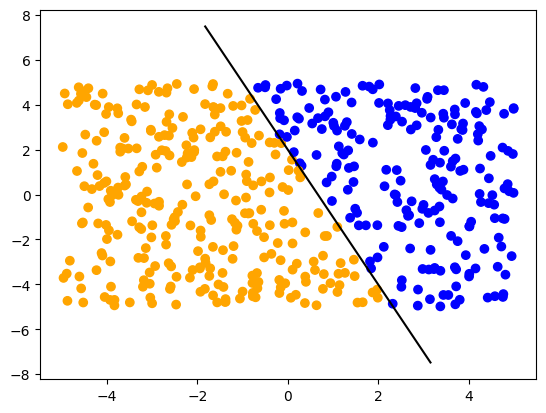

In [462]:
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=1, noise_frac=0, samples=500)
p.plotData(show_seperator=True)

100%|██████████| 25/25 [00:00<00:00, 29.32it/s]


Accuracy = 0.992


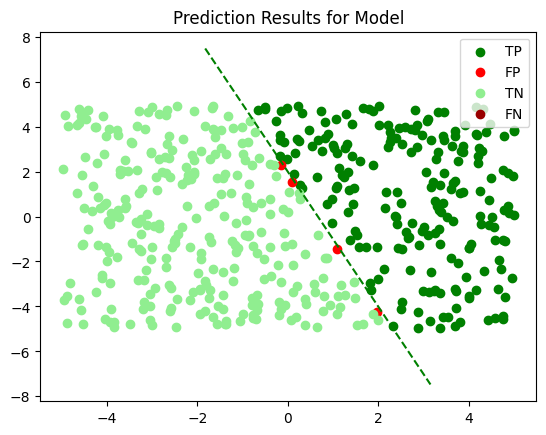

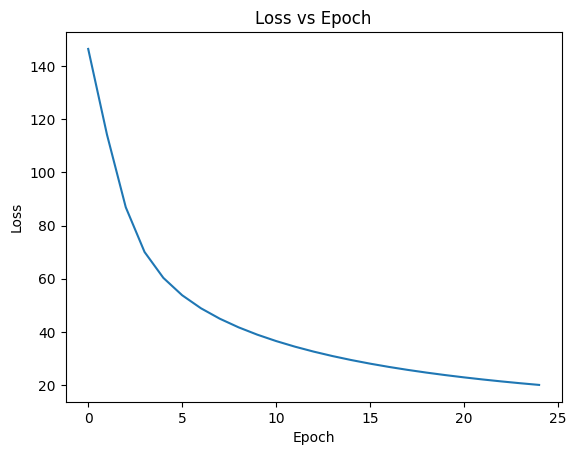

In [465]:
mlp = MultiLayerPerceptron(
    epochs=25, 
    lr=0.1,
    activation="sigmoid",
    input_layer=2, 
    hidden_layers=[2],
    output_layer=1)
    
mlp.fit(X,y, batch_size=10)
pred = mlp.predict(X)
p.plotPred(pred, show_correct=True)
mlp.plot_loss()

## SKlearn MLP for comparison

Accuracy = 1.0


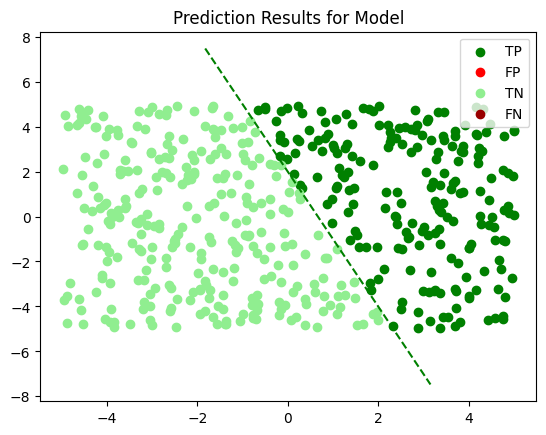

In [466]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(3,2), activation='logistic', solver='sgd', learning_rate_init=0.1,learning_rate='constant', max_iter=300)
clf.fit(X, y)
pred = clf.predict(X)
p.plotPred(pred, show_correct=True)